## Setup : Sampling from image dataset and retrieving captions

In [ ]:
from PIL import Image
import itertools, random
import glob,os, json
import random,shutil
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from balance_training_set import read_data,get_data,split_train_data

In [614]:
def get_traincaptions(ids, n_samples):
    
    target_folder = 'trainfolder/'
    train_set = []
    filenames = {}
    captions = {}
    print("Getting samples: ",n_samples, "nos.")
    
    train_set = [id for id in random.sample(ids, n_samples)]
        
    with open('captions_train2014.json') as file:
        coco_data = json.load(file)
    for item in coco_data['images']:
        if len(filenames) == len(train_set):
            break
        if item['id'] in train_set:
            filenames[item['id']] = item['file_name']
    
    for item in coco_data['annotations']:
        if len(captions)==len(train_set):
            break
        if item['image_id'] in train_set:
            filename = filenames[item['image_id']]
            if filename in captions:
                captions[filename] += [item['caption']]
            else:
                captions[filename] = [item['caption']]
    for image in captions.keys():
        image = "train2014/" + image 
        shutil.copy(image, target_folder)
    print("Copied sampled images to {}".format(target_folder))
    return captions
    

In [615]:
def get_captions(n_samples):
    with open('instances_train2014.json') as file:
        data = json.load(file)
    all_ids = []
    for item in data['annotations']:
        if item['category_id'] == 1:
            all_ids.append(item['image_id'])

    captions = get_traincaptions(all_ids, n_samples)
    all_captions = []
    all_captions.extend(itertools.chain(*(value for key,value in captions.items())))
    print("Retrieved captions for sampled images.")
    return captions, all_captions

In [616]:
captions, all_captions = get_captions(1000)

Getting samples:  1000 nos.
Copied sampled images to trainfolder/
Retrieved captions for sampled images.


### Example from sampled training set

In [617]:
captions

{'COCO_train2014_000000004377.jpg': ['A group of people playing a game of croquet.',
  'A game of croquet is being played in a back yard.',
  'Two guys and a girl playing croquet in the yard.',
  'A group of four people playing croquet on a lawn.',
  'A group of friends enjoy a game of croquet on a grassy fenced in field.'],
 'COCO_train2014_000000294933.jpg': ['A group of people waiting to get off the ferry on vespas.',
  'People on scooters are parked and viewing something.',
  'People on a boat crossing a body of water',
  'A woman and a man riding motor bikes next to a red compact car.',
  'A group of people on mopeds and in a car looking in the distance.'],
 'COCO_train2014_000000012459.jpg': ['A group of skiers some in costume in the snow.',
  'Skiers are all bundled up, one person is wearing a cow suit.',
  'Five people, all dressed in costumes, wearing skis on a mountain.',
  '5 adults strangely dressed about to snow ski',
  'A group of people dresses up in costumes to go skiin

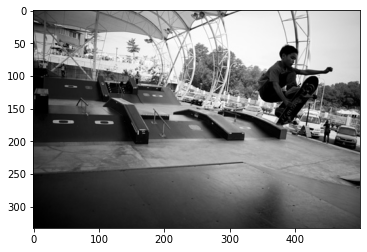

trainfolder/COCO_train2014_000000457427.jpg
['A boy doing a trick on a skateboard in a park of ramps.',
 'A kid on a skateboard does tricks inside the outdoor theater. ',
 'A boy at a skate park riding on his skateboard. ',
 'A young skateboarder is doing a trick in the air',
 'A boy pulling a trick on a skateboard at a skate park.']


In [620]:
image_path = "trainfolder/" + random.choice(list(captions.keys()))
img=mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.show()
print(image_path)
pprint(captions[image_path.split('/')[1]][0:])


# Bias Analysis

### Identifying gender nouns, their associated verbs 

CC coordinating conjunction <br>
CD cardinal digit<br>
DT determiner<br>
EX existential there (like: “there is” … think of it like “there exists”)<br>
FW foreign word<br>
IN preposition/subordinating conjunction<br>
JJ adjective ‘big’<br>
JJR adjective, comparative ‘bigger’<br>
JJS adjective, superlative ‘biggest’<br>
LS list marker 1)<br>
MD modal could, will<br>
NN noun, singular ‘desk’<br>
NNS noun plural ‘desks’<br>
NNP proper noun, singular ‘Harrison’<br>
NNPS proper noun, plural ‘Americans’<br>
PDT predeterminer ‘all the kids’<br>
POS possessive ending parent’s<br>
PRP personal pronoun I, he, she<br>
PRP\$ possessive pronoun my, his, hers<br>
RB adverb very, silently,<br>
RBR adverb, comparative better<br>
RBS adverb, superlative best<br>
RP particle give up<br>
TO, to go ‘to’ the store.<br>
UH interjection, errrrrrrrm<br>
VB verb, base form take<br>
VBD verb, past tense took<br>
VBG verb, gerund/present participle taking<br>
VBN verb, past participle taken<br>
VBP verb, sing. present, non-3d take<br>
VBZ verb, 3rd person sing. present takes<br>
WDT wh-determiner which<br>
WP wh-pronoun who, what<br>
WP$ possessive wh-pronoun whose<br>
WRB wh-abverb where, when<br>

### Define gender nouns, pronouns (expand/reduce lists as required)

In [621]:
import nltk
from nltk import word_tokenize, pos_tag
from collections import defaultdict

# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')

gender_nouns = ['man','woman','person','boy','girl','men','women','someone',
                'lady','boys','girls','gentleman','ladies','gentlemen','person','people',
                'child','pedestrian','guy','male','female',
               'passenger']
gender_pronouns = ['his','he','hers','her''she','its','it']
verb_tags = ['VBG','VBD','VBN','VB']
adj_tags = ['JJ','JJR','JJS']
noun_tags = ['NN','NNS','NNP','NNPS']


In [622]:
def get_tag_dicts(get_tags):
    gender_tags_dict = defaultdict(list)
    pronoun_tags_dict = defaultdict(list)
#     print(pronoun_tags_dict)
    # gender_tags_dict = dict.fromkeys(gender_nouns, [])
    # pronoun_tags_dict = dict.fromkeys(gender_pronouns, [])

    for caption in all_captions:
        # verbs : VBG, VBD, VBN
        tokens = word_tokenize(caption)

        if any(nn in tokens for nn in gender_nouns) or any(pn in tokens for pn in gender_pronouns):
            tags = pos_tag(tokens)

            only_tags = [tag[1] for tag in tags]
            if any(get_tag in only_tags for get_tag in get_tags):
                only_verbs = [tag[0] for tag in tags if tag[1] in get_tags]
                if set(gender_nouns).intersection(tokens):   

                    for nn in set(gender_nouns).intersection(tokens):

                        gender_tags_dict[nn].extend(only_verbs)

                if set(gender_pronouns).intersection(tokens):
                    for pn in set(gender_pronouns).intersection(tokens):
    #                     print(pn, pronoun_tags_dict[pn])
                        pronoun_tags_dict[pn].extend(only_verbs)
    
    return gender_tags_dict, pronoun_tags_dict

### lists of words associated with gender nouns and pronouns

In [623]:
gender_dict, pronoun_dict = get_tag_dicts(verb_tags)  
gender_count,pronoun_count = {},{}  

### Most frequent items (verbs/adj/nouns) associated with each gender noun/pronoun

In [624]:
def top_n_items(nn='woman',pos='verb',count=0):
    global gender_count, pronoun_count
    corresp_tags = {'adj': adj_tags, 'verb':verb_tags, 'noun':noun_tags}
    gender_dict, pronoun_dict = get_tag_dicts(corresp_tags[pos])  
    gender_count,pronoun_count = {},{}
    
    for (key1, value1) in gender_dict.items():
        gender_count[key1] = set([(i,value1.count(i)) for i in value1 if i not in gender_nouns])
    for (key2, value2) in pronoun_dict.items():   
        pronoun_count[key2] = set([(i,value2.count(i)) for i in value2 if i not in gender_nouns])     
    
    dictionary = gender_count if nn in gender_nouns else pronoun_count
    if count==0:
        return
    print(sorted(dict(dictionary[nn]), key = dict(dictionary[nn]).get, reverse=True)[:count])

In [625]:
top_n_items('woman','verb',15)

['holding', 'standing', 'sitting', 'walking', 'riding', 'wearing', 'looking', 'playing', 'talking', 'feeding', 'eating', 'cutting', 'dressed', 'carrying', 'taking']


In [626]:
top_n_items('man','verb',15)

['riding', 'holding', 'standing', 'sitting', 'walking', 'wearing', 'playing', 'looking', 'flying', 'taking', 'doing', 'talking', 'watching', 'reading', 'cutting']


In [630]:
def counts():
    global all_count,pro_all_count
    all_count = {}
    pro_all_count = {}    
    for item1 in gender_count:
        all_count[item1] = {each[0]:each[1] for each in gender_count[item1]}
    for item2 in pronoun_count:
        pro_all_count[item2]= {each[0]:each[1] for each in pronoun_count[item2]}

### Calculating the Gender bias (if any) in training set

In [631]:
def bias(gender1 = 'man',gender2 = 'woman'):
    global bias_dict1,bias_dict2,data
    # data : gender nouns or pronouns : all_count or pro_all_count
#     data = all_count.copy() if gender in gender_nouns else pro_all_count.copy()
    counts()
    data = all_count.copy()
    
    dictionary = set([a for key,values in data.items() for a in values if key==gender1 or key==gender2])    
     
    bias_dict1, bias_dict2 = {}, {} 
    for word in dictionary:
        gender1_count = data[gender1].get(word,0)
        gender2_count = data[gender2].get(word,0)
        if gender1_count!=0 and gender2_count!=0: bias_dict1[word] = gender1_count/(gender1_count+gender2_count)
        if gender1_count!=0 and gender2_count!=0: bias_dict2[word] = gender2_count/(gender1_count+gender2_count)            

In [640]:
gender1 = 'man'
gender2 = 'woman'
top_n_items(pos='verb',count=0)
bias()
for i in sorted(bias_dict1, key=bias_dict1.get,reverse=True):
    if bias_dict1[i]>0.5:
        print(i,round(bias_dict1[i],4),data[gender1][i])

watching 0.9167 11
covered 0.8889 8
crossing 0.8571 6
running 0.8333 5
being 0.8333 5
riding 0.8257 90
flying 0.8235 14
jumping 0.8182 9
giving 0.8 8
catching 0.8 8
surfing 0.8 4
using 0.7778 7
preparing 0.75 3
kneeling 0.75 3
held 0.75 3
taking 0.7368 14
swinging 0.7273 8
skiing 0.7143 5
observing 0.6667 2
playing 0.6667 26
checking 0.6667 2
waiting 0.6667 4
showing 0.6667 2
hit 0.6364 7
standing 0.6222 84
floating 0.6 3
posing 0.6 3
wearing 0.6 27
having 0.6 3
resting 0.6 3
sitting 0.5844 45
dressed 0.5714 8
cutting 0.5625 9
holding 0.5584 86
walking 0.5424 32
looking 0.5312 17
talking 0.5217 12


In [642]:
for i in sorted(bias_dict2, key=bias_dict2.get,reverse=True):
    if bias_dict2[i]>0.5:
        print(i,round(bias_dict2[i],4),data[gender2][i])

eating 0.8 8
helping 0.6667 2
serve 0.6667 2
leaning 0.6667 2
laying 0.6 3
getting 0.6 3
carrying 0.5455 6
feeding 0.5333 8


In [632]:
top_n_items(pos='noun',count=0)
bias() 
for i in sorted(bias_dict1, key=bias_dict1.get,reverse=True):
    if bias_dict1[i]>0.5:
        print(i,round(bias_dict1[i],4),data[gender1][i])

skateboard 0.9538 62
frisbee 0.9412 16
motorcycle 0.9091 20
dirt 0.9 9
field 0.8966 26
uniform 0.875 7
elephant 0.8571 6
video 0.8571 6
middle 0.8571 6
tie 0.8571 6
sand 0.8571 6
refrigerator 0.8571 6
game 0.8387 26
something 0.8333 5
home 0.8333 10
airport 0.8333 5
road 0.8333 10
wave 0.8182 9
bike 0.8182 18
children 0.8182 9
boat 0.8182 9
group 0.8125 13
top 0.8077 21
ball 0.8056 29
living 0.8 4
rail 0.8 4
air 0.8 8
business 0.8 4
fork 0.8 4
Frisbee 0.7857 11
food 0.7826 18
street 0.7778 49
side 0.7727 17
shirt 0.7714 27
plate 0.7692 10
bathroom 0.75 3
board 0.75 9
city 0.75 9
wall 0.75 3
crowd 0.75 15
stuffed 0.75 3
kitchen 0.75 6
ocean 0.75 3
path 0.75 3
image 0.75 3
sky 0.75 3
suit 0.75 9
device 0.75 3
blue 0.75 3
piece 0.75 3
paper 0.75 3
building 0.75 6
grass 0.7333 11
front 0.7308 38
mountain 0.7143 5
horse 0.7143 20
day 0.7143 5
onlookers 0.6667 2
Young 0.6667 2
motor 0.6667 2
sunglasses 0.6667 2
swing 0.6667 2
shirts 0.6667 2
jacket 0.6667 6
scout 0.6667 2
attire 0.6667 2
cro

In [633]:
bias('woman','man')
for i in sorted(bias_dict1, key=bias_dict1.get,reverse=True):
    if bias_dict1[i]>0.5:
        print(i,round(bias_dict1[i],4),data['woman'][i])

dress 0.9 9
bananas 0.8571 6
hair 0.8571 6
Man 0.8333 5
bear 0.8 4
event 0.75 3
surfboards 0.75 3
head 0.7273 8
wine 0.7143 5
mirror 0.6667 2
float 0.6667 2
walking 0.6667 2
umbrellas 0.6667 2
farmers 0.6667 2
suits 0.6667 2
Wii 0.6667 2
standing 0.6667 4
Christmas 0.6667 2
surf 0.6667 2
barrier 0.6667 2
bikini 0.6667 2
baby 0.6667 4
signs 0.6667 2
arms 0.6667 2
costume 0.6667 2
pink 0.625 5
smiling 0.6 3
camera 0.6 6
giraffe 0.6 3
bed 0.6 6
hands 0.5714 4
glass 0.5556 5
table 0.5429 19
sidewalk 0.5385 7
bench 0.5385 7
racket 0.5357 15
cake 0.5263 20
court 0.5143 18


Men: riding, walking, swinging, reading, dressed, playing, skiing, trying, standing, sitting, preparing, laying, holding <br>
Women: smiling, eating,(also) watching, using, cutting, posing

## Balancing dataset from module & checking for bias

In [644]:
img_capts,_,imgs=read_data('captions_train2014.json')
_,catg_imgs,_=read_data('instances_train2014.json')
train_data=split_train_data(img_capts,catg_imgs)
captions,all_captions = get_data(img_capts,imgs,train_data)

male 33
female 33
neutral 34


In [650]:
top_n_items(pos='verb',count=0)
bias()
print("------MEN-----")
for i in sorted(bias_dict1, key=bias_dict1.get,reverse=True):
    if bias_dict1[i]>0.5:
        print(i,round(bias_dict1[i],4),data[gender1][i])
print("------WOMEN-----")
for i in sorted(bias_dict2, key=bias_dict2.get,reverse=True):
    if bias_dict2[i]>0.5:
        print(i,round(bias_dict2[i],4),data[gender2][i])

------MEN-----
riding 0.8438 27
holding 0.5652 13
sitting 0.5625 18
------WOMEN-----
standing 0.7143 5


## Presence of bias has significantly reduced in the balanced training set (verbs)!

In [648]:
top_n_items(pos='noun',count=0)
bias() 
print("------MEN-----")
for i in sorted(bias_dict1, key=bias_dict1.get,reverse=True):
    if bias_dict1[i]>0.5:
        print(i,round(bias_dict1[i],4),data[gender1][i])
print("------WOMEN-----")
for i in sorted(bias_dict2, key=bias_dict2.get,reverse=True):
    if bias_dict2[i]>0.5:
        print(i,round(bias_dict2[i],4),data[gender2][i])

------MEN-----
bike 0.9167 11
street 0.875 7
road 0.8571 6
motorcycle 0.85 17
surfboard 0.8333 5
pizza 0.8333 5
living 0.6667 2
back 0.6667 2
bench 0.6667 4
controller 0.6667 2
bowl 0.6667 2
sidewalk 0.6667 2
motorbike 0.6667 2
side 0.6667 2
dog 0.6429 9
game 0.6 3
computer 0.6 3
horse 0.5789 11
------WOMEN-----
cat 0.8182 9
remote 0.75 3
top 0.75 3
stone 0.6667 2
phone 0.6667 4
laptop 0.6 3
front 0.5556 5


### Improved for nouns as well.